Goal: Compare NN vs. threshold in terms of robustness to time-shifted input
- For variable-size models

In [1]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys 
sys.path.append('../training')
import pickle
import time
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model as load_tf_model
from qkeras.utils import _add_supported_quantized_objects

import pandas as pd

# locals 
from save_data import process_data
from threshold import ThresholdModel

In [2]:
# START_WINDOW = 285
# END_WINDOW = 385

# START_WINDOW = 150
# END_WINDOW = 350

# START_WINDOW = 150
# END_WINDOW = 550

START_WINDOW = 0
END_WINDOW = 500

# START_WINDOW = 0
# END_WINDOW = 770


#MODEL_DIR = f'models/model_{START_WINDOW}_{END_WINDOW}'
DIRECTION = "both"
PADDING = "zero"
MAX_SHIFT = 200 #570
INCREMENT = 20
NOISE_LO = -4
NOISE_HI = 4
SHIFT_STR = f"{DIRECTION}shift_{PADDING}padding_maxshift{MAX_SHIFT}_inc{INCREMENT}_noisem{np.abs(NOISE_LO)}p{NOISE_HI}"
MODEL_DIR = os.path.join(f'models/model_{START_WINDOW}_{END_WINDOW}', SHIFT_STR)

NN_FILENAME = os.path.join(f'models/model_{START_WINDOW}_{END_WINDOW}', f"qmodel_{START_WINDOW}_{END_WINDOW}.h5")
NN_SHIFTED_FILENAME = os.path.join(MODEL_DIR, f"qmodel_{START_WINDOW}_{END_WINDOW}.h5")
THRESH_FILENAME = os.path.join(f'models/model_{START_WINDOW}_{END_WINDOW}', 'threshold_model.json')

FPGA_DATA_DIR = '../data/fpga_testing'

## 1. Load data

In [3]:
df = pd.read_csv(FPGA_DATA_DIR + '/malab_g_state_A_fpga.csv', header=None)
X_g = df.values
y_g = np.zeros((X_g.shape[0],))

df = pd.read_csv(FPGA_DATA_DIR + '/malab_e_state_A_fpga.csv', header=None)
X_e = df.values
y_e = np.ones((X_e.shape[0],))

X = np.concatenate((X_g, X_e), axis=0)
y = np.concatenate((y_g, y_e), axis=0)

shuffler = np.random.permutation(X.shape[0])
X = X[shuffler]
y = y[shuffler]

## 2. Load models

In [4]:
assert os.path.exists(NN_FILENAME), "ERROR: Trained neural network not found"
co = {}
_add_supported_quantized_objects(co)
nn_model = load_tf_model(NN_FILENAME, custom_objects=co, compile=False)

co = {}
_add_supported_quantized_objects(co)
nn_shifted_model = load_tf_model(NN_SHIFTED_FILENAME, custom_objects=co, compile=False)


assert os.path.exists(THRESH_FILENAME), "ERROR: Trained threshold-model not found"
thresh_model = ThresholdModel()
thresh_model.load(THRESH_FILENAME)

y_nn_pred = nn_model.predict(X[:, 2*START_WINDOW:2*END_WINDOW])
print(f"Normal NN accuracy: {accuracy_score(y, np.argmax(y_nn_pred, axis=1))}")

y_nn_shifted_pred = nn_shifted_model.predict(X[:, 2*START_WINDOW:2*END_WINDOW])
print(f"Time-shift invariant NN accuracy: {accuracy_score(y, np.argmax(y_nn_shifted_pred, axis=1))}")

y_thresh_pred = thresh_model.predict(X[:, 2*START_WINDOW:2*END_WINDOW])
print(f"Threshold accuracy: {accuracy_score(y, y_thresh_pred)}")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


313/313 [==============================] - 1s 2ms/step
Normal NN accuracy: 0.9584
313/313 [==============================] - 1s 2ms/step
Time-shift invariant NN accuracy: 0.9492
Threshold accuracy: 0.9551


## 3. Functions to time-shift input data

Left or right, zero- or noise-padded

In [6]:
def l_shift_data_zero_padded(X, start, end, offset):
    extended_X = np.pad(X, pad_width=((0, 0), (0, offset*2)), mode='constant', constant_values=0)
    return extended_X[:,(start+offset)*2:(end+offset)*2]

def r_shift_data_zero_padded(X, start, end, offset):
    extended_X = np.pad(X, pad_width=((0, 0), (offset*2, 0)), mode='constant', constant_values=0)
    return extended_X[:,start*2:end*2]

def l_shift_data_noise_padded(X, start, end, offset, noise_lo = np.nan, noise_hi = np.nan):
    if offset == 0:
        return X[:,(start+offset)*2:(end+offset)*2]
    else:
        num_rows = X.shape[0]
        noise = np.random.uniform(noise_lo, noise_hi, size=(num_rows*offset*2)).astype(int)
        noise = noise.reshape(-1, offset*2)
        return np.hstack((X, noise))[:,(start+offset)*2:(end+offset)*2]

def r_shift_data_noise_padded(X, start, end, offset, noise_lo = np.nan, noise_hi = np.nan):
    if offset == 0:
        return X[:,start*2:end*2]
    else:
        num_rows = X.shape[0]
        noise = np.random.uniform(noise_lo, noise_hi, size=(num_rows*offset*2)).astype(int)
        noise = noise.reshape(-1, offset*2)
        return np.hstack((noise, X))[:,start*2:end*2]

SHIFT_FUNCTION_DICT = {("left", "zero"): l_shift_data_zero_padded,
                      ("right", "zero"): r_shift_data_zero_padded,
                      ("left", "noise"): l_shift_data_noise_padded,
                      ("right", "noise"): r_shift_data_noise_padded}

## 4. Function to evaluate model robustness for range of time-shifts

In [7]:
def time_shift_eval(model,
                    direction = "left", #"right"
                    padding = "zero", # "noise"
                    noise_range = [-4, 4],
                    y_one_hot = False):

    # Get time function, kwargs 
    time_shift_func = SHIFT_FUNCTION_DICT[(direction, padding)]
    if padding=="zero":
        kwargs = {}
    elif padding=="noise":
        kwargs = {"noise_lo": noise_range[0],
                  "noise_hi": noise_range[1]}
    else:
        raise NotImplementedError("'padding' argument must be in ['zero', 'noise']")

    # Check accuracy for each size of time-shift
    accuracy_values = np.zeros((770,), dtype=np.float64)
    for offset in tqdm(range(770)):
        X_shifted = time_shift_func(X, START_WINDOW, END_WINDOW, offset, **kwargs)
        y_pred = model.predict(X_shifted, verbose = False)
        if y_one_hot:
            y_pred = np.argmax(y_pred, axis = 1)
        accuracy_values[offset] = accuracy_score(y, y_pred)
        
    return accuracy_values            

## 5. Test all three models for all time-shifts

100%|█████████████████████████████████████████| 770/770 [02:36<00:00,  4.91it/s]


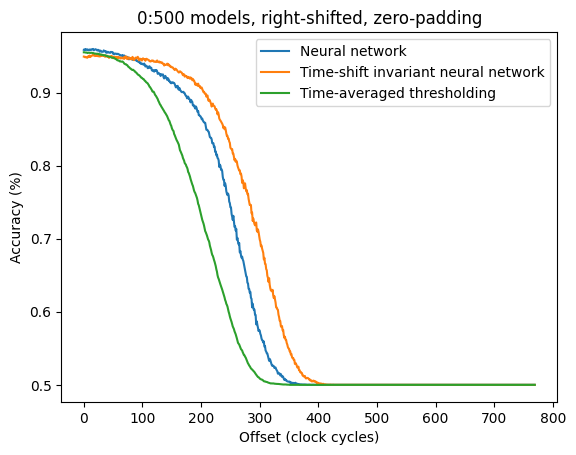

100%|█████████████████████████████████████████| 770/770 [03:44<00:00,  3.43it/s]


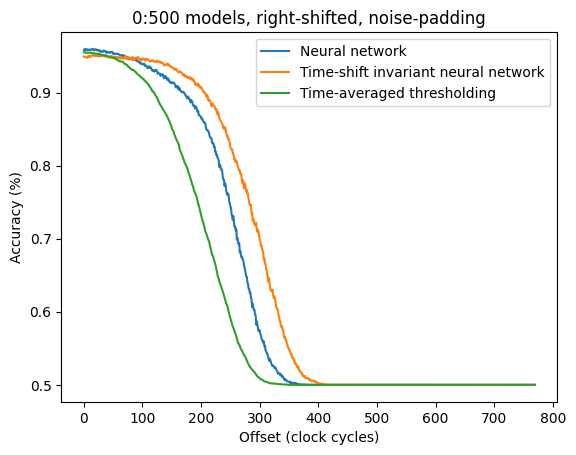

100%|█████████████████████████████████████████| 770/770 [02:40<00:00,  4.79it/s]


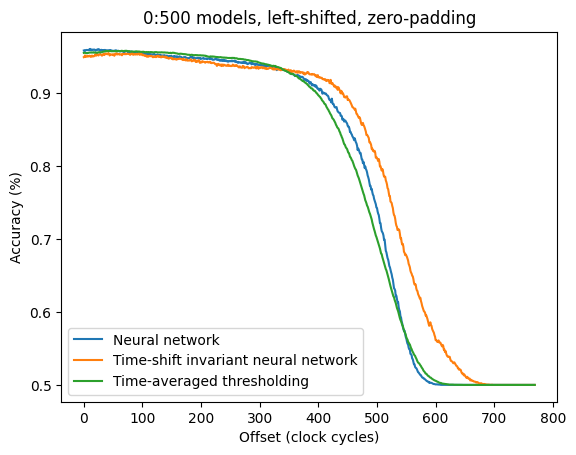

100%|█████████████████████████████████████████| 770/770 [03:36<00:00,  3.55it/s]


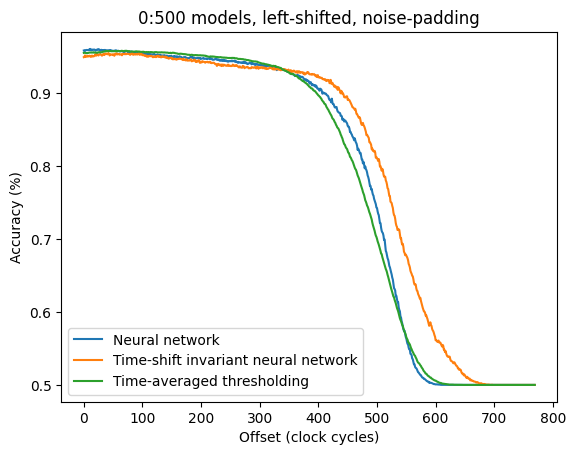

Duration: 80.0 minutes, 16.867764711380005 seconds


In [8]:
SAVE_DIR = os.path.join("shifted_inputs_study", SHIFT_STR, f"{START_WINDOW}_{END_WINDOW}")
os.makedirs(SAVE_DIR, exist_ok = True)

tic = time.time()

for direction in ["right", "left"]:
    for padding in ["zero", "noise"]:
        nn_acc = time_shift_eval(nn_model, direction = direction, padding = padding, y_one_hot = True)
        nn_shifted_acc = time_shift_eval(nn_shifted_model, direction = direction, padding = padding, y_one_hot = True)
        thresh_acc = time_shift_eval(thresh_model, direction = direction, padding = padding, y_one_hot = False)

        plt.figure()
        plt.plot(nn_acc, label = "Neural network")
        plt.plot(nn_shifted_acc, label = "Time-shift invariant neural network")
        plt.plot(thresh_acc, label = "Time-averaged thresholding")
        plt.xlabel("Offset (clock cycles)")
        plt.ylabel("Accuracy (%)")
        plt.title(f"{START_WINDOW}:{END_WINDOW} models, {direction}-shifted, {padding}-padding")
        plt.legend()
        
        plt.savefig(os.path.join(SAVE_DIR, f"{direction}_{padding}.png"))
        plt.show()
        plt.close()

toc = time.time()
dur = toc - tic
print(f"Duration: {dur//60} minutes, {dur%60} seconds")